In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e3/sample_submission.csv
/kaggle/input/playground-series-s4e3/train.csv
/kaggle/input/playground-series-s4e3/test.csv


In [2]:
df = pd.read_csv('/kaggle/input/playground-series-s4e3/train.csv')
X = df.iloc[:,1:-7]
y = df.iloc[:,-7:]

idxs = np.random.choice(range(len(X)), 5*len(X)//6, replace=False)
idxs_val = [i for i in range(len(X)) if i not in idxs]

X_train=X.iloc[idxs,:]
y_train=y.iloc[idxs,:]
X_val = X.iloc[idxs_val,:]
y_val = y.iloc[idxs_val,:]

In [159]:
def check_corr():
    col = 'Pastry'
    t = pd.concat((X_train,y_train[col]),axis=1).corr().iloc[:,-1]
    #print(t)
    for col in y_train.iloc[:,1:]:
        c = pd.concat((X_train,y_train[col]),axis=1).corr().iloc[:,-1]
        t = pd.concat((t,c),axis=1)

    sns.heatmap(t.iloc[:-7,:])

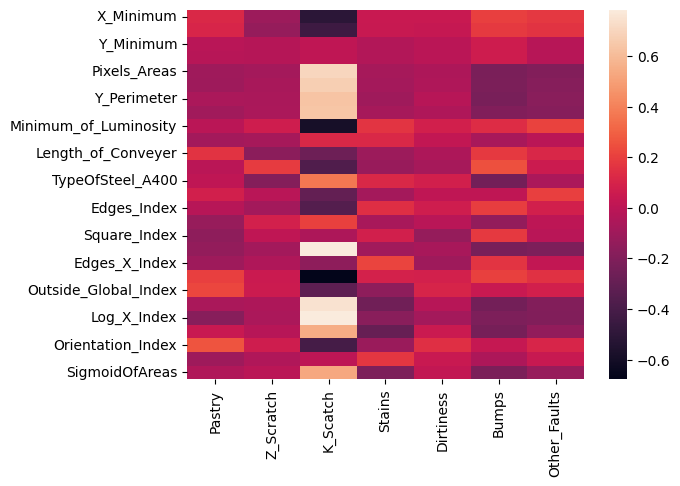

In [160]:
check_corr()

In [156]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
def check_number_of_PC():
    exp_var = []
    mms = MinMaxScaler()
    for i in range(X.shape[1]):
        
        pca = PCA(n_components = i)
        pca.fit(mms.fit_transform(X))
        exp_var.append(sum(pca.explained_variance_ratio_))
        
    sns.lineplot(x=range(0,X.shape[1]), y=exp_var)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


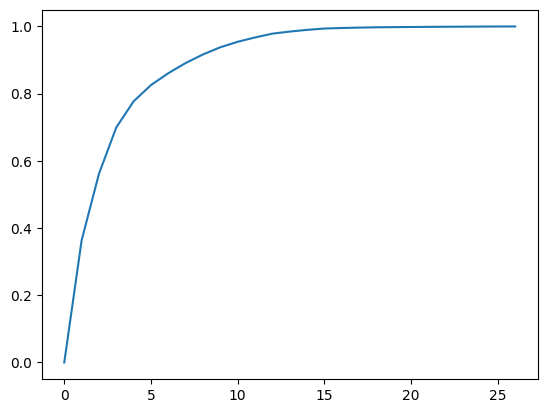

In [157]:
check_number_of_PC()

In [141]:
from sklearn.model_selection import cross_val_score

In [68]:
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

In [114]:
def train_predict(estimator,X_train,y_train, X_val, y_val):
    res_preds = np.empty((y_val.shape[0],0))
    train_roc = []
    for col in y:
        estimator.fit(X_train,y_train[col])
        
        pr = estimator.predict_proba(X_train)[:,1]
        train_roc.append(roc_auc_score(y_train[col], pr))
        
        preds = np.expand_dims( estimator.predict_proba(X_val)[:,1], axis=1 )
        res_preds = np.concatenate((res_preds,preds),axis=1)
        
    return res_preds, train_roc

In [115]:
from sklearn.metrics import roc_auc_score
def get_avg_roc_auc(target, predicted):
    roc =  []
    for i in range(target.shape[1]):
        roc.append(roc_auc_score(target.iloc[:,i], predicted[:,i]))
    return roc

In [116]:
from sklearn.pipeline import Pipeline

In [ ]:
max_depth=5,learning_rate=0.0007, n_estimators=1200,verbose = -1

In [138]:
pipe = Pipeline([('scaler', MinMaxScaler()), ('LGBMClassifier', LGBMClassifier(verbose=-1))])
res_preds,train_roc = train_predict(pipe,X_train,y_train, X_val, y_val)
roc = get_avg_roc_auc(y_val, res_preds)

In [139]:
print('train',train_roc)
print('validation',roc)
print(np.mean(train_roc), np.mean(roc))

train [0.9892425890238337, 0.9990516453318278, 0.9989744867574994, 1.0, 0.9998916021206568, 0.9244333682374173, 0.8684168547549254]
validation [0.8553931461888162, 0.959859196147125, 0.9857731194028702, 0.9921315367115184, 0.8760683426821456, 0.7966615365154327, 0.7023517295863664]


In [151]:
def cross_validate(est, X,y,cv):
    score = []
    for col in y.columns:
        s = cross_val_score(est,X,y[col],scoring='roc_auc', cv=cv)
        score.append(s)
    return score



In [ ]:
pipe = Pipeline([('scaler', MinMaxScaler()), ('LGBMClassifier', LGBMClassifier(verbose=-1))])

In [152]:
scores = cross_validate(pipe,X,y,cv=5)
print(scores)
print(np.mean(scores))

[array([0.84295343, 0.87022739, 0.86502096, 0.87309859, 0.85953853]), array([0.94921681, 0.96141214, 0.95836481, 0.95456438, 0.96464097]), array([0.98428998, 0.98578833, 0.98545088, 0.98537065, 0.98183591]), array([0.99385024, 0.99306477, 0.99024505, 0.99227235, 0.99299153]), array([0.88783604, 0.87180948, 0.88563772, 0.89990343, 0.85259603]), array([0.81022336, 0.80593135, 0.79924308, 0.80427589, 0.80499645]), array([0.69307024, 0.69033776, 0.68731397, 0.70250669, 0.69982681])]
0.8822773144990318


In [153]:
!git 

fatal: not a git repository (or any parent up to mount point /kaggle)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).
